# Predict with future weather

In [1]:
from toolbox import *

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import pickle
import glob
import os

In [2]:
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, SelectFromModel

from sklearn.model_selection import GridSearchCV

In [4]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

## Unpickle model

In [5]:
# load model
if True:
    name = 'HGBoost'
    
    with open(f'./models/{name}.pkl', 'rb') as file:
        model = pickle.load(file)
    
    model#.best_params_

## Load groundwater station data

In [6]:
gs = load_groundwater_station_data('./data/groundwater/bergstraße/gw_stations_bergstraße.csv')
g = load_groundwater_data('./data/groundwater/bergstraße/gw.csv')

gs_agg = calc_aggregate_station_data(gs, g)
gs_agg = calc_initial_station_data(gs_agg, g, initial_n_years=5) 
gs_agg = gs_agg.drop('water_temp_mean', axis='columns')

In [7]:
#gs_agg[gs_agg.isna().any(axis=1)]
gs_agg = gs_agg.dropna()
#gs_agg.info()

### Create regional clusters from gw stations

A good number of clusters is 10-12. Re-run if station data is changed.

In [8]:
#explore_clusters(gs_agg[['x', 'y']])

In [9]:
labels, centers = apply_clusters(gs_agg[['x', 'y']], 12, scale=False)

#plot_clusters(gs_agg[['x', 'y']], labels, centers)

# Add clusters to stations
gs_agg['reg_clusters'] = labels
#gs_agg['reg_clusters'] = 0

## Load weather scenarios

In [10]:
scenario_folder = './data/weather_future'
scenarios = {}

for path in glob.iglob(f'{scenario_folder}/add*.csv'):
    scenario_name = os.path.splitext(os.path.basename(path))[0]
    print(scenario_name)
    w = load_weather_data(f'./data/weather_future/{scenario_name}.csv')
    w['date'] = w.index
    #w.info()
    scenarios[scenario_name] = w

add_t+4_p+10
add_ref
add_t+4_p-10


## Predict future groundwater

In [11]:
# restrict data to these columns
restrict_to_cols = ['station_id',
        'date',
        #'water_depth',
        'ground_elev',
        'x', 'y',
        'geometry',
        'reg_clusters',
        'ini_years_water_depth_mean',
        'ini_years_water_depth_std',
        'ini_years_water_depth_min',
        'ini_years_water_depth_max',
        'precip_mean',
        'tmean_mean',
        'moisture_mean',
        'precip_mean_prev_2d_sum',
        'precip_mean_prev_7d_sum',
        'precip_mean_prev_30d_sum',
        'precip_mean_prev_90d_sum',
        'precip_mean_prev_1y_sum',
        'precip_mean_prev_3y_sum',
        'tmean_mean_prev_2d_mean',
        'tmean_mean_prev_7d_mean',
        'tmean_mean_prev_30d_mean',
        'tmean_mean_prev_90d_mean',
        'tmean_mean_prev_1y_mean',
        'tmean_mean_prev_3y_mean'
       ]

reserve_cols_as_info = ['station_id', 'date', 'geometry']

In [12]:
predictions = {}

for scenario_name in scenarios:
    print(scenario_name)
    w = scenarios[scenario_name]
    df = gs_agg.merge(w, how='cross')
    df = df[restrict_to_cols]
    df = df.dropna()

    info = df[reserve_cols_as_info].copy()

    X = df.copy().drop(reserve_cols_as_info, axis=1)

    y_pred = pd.DataFrame(model.predict(X), columns=['pred_water_depth'])
    y_pred.index = info.index

    pred = pd.concat([info, X, y_pred], axis='columns')

    predictions[scenario_name] = pred

    if True:
        pred.drop('geometry', axis=1).to_feather(f'./data/predictions/{scenario_name}.feather')

add_t+4_p+10
add_ref
add_t+4_p-10


### Analyse prediction

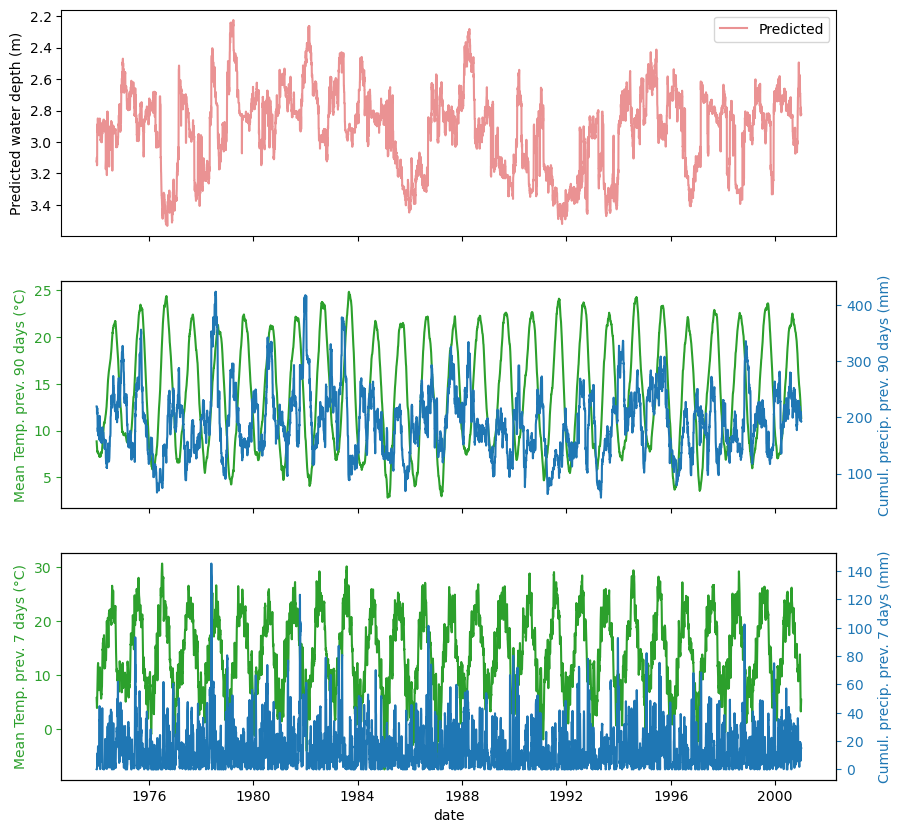

In [13]:
pred = predictions['add_t+4_p+10']

data = pred.loc[pred.station_id == pred.station_id.unique()[22]]

plot_predicted_data(data,
                  #pd.to_datetime('2035-01-01'), pd.to_datetime('2045-01-10'),
                  #pd.to_datetime('2040-01-01'), pd.to_datetime('2044-01-10')
                  #save=True
                 )

#plt.savefig('./figs/test.png', bbox_inches='tight')

## Predict past groundwater for all stations

In [16]:
w = load_weather_data('./data/weather_collections/weather_daily_region.csv')
w = calc_cumulative_weather(w)

In [17]:
g_merged = merge_groundwater_data(g, gs_agg)
#g_merged.describe()

In [18]:
#g_merged.head()

In [19]:
m = pd.merge(g_merged, w,
             how='left', left_index=True, right_index=True)

# restrict data to the reference period
m = m.loc[m.date > pd.to_datetime('1971-01-01')]

# drop all rows with a date after the weather data cutoff date
m = m.loc[m.date <= pd.to_datetime('2020-12-31')]

m = m.dropna(subset=['station_id_count'])

m['week_of_year'] = m['date'].dt.isocalendar().week

In [20]:
# restrict data to these columns
df = m[restrict_to_cols + ['water_depth']]
#df.info()

In [21]:
#df[df.isna().any(axis=1)]

In [22]:
df = df.dropna()

In [23]:
info = df[reserve_cols_as_info].copy()
X = df.copy().drop(reserve_cols_as_info, axis=1)

In [24]:
y_pred = pd.DataFrame(model.predict(X), columns=['pred_water_depth'])
y_pred.index = info.index

In [25]:
pred_past = pd.concat([info, X, y_pred], axis='columns')
#pred_past.head()

In [26]:
if True:
    # for saving in feather format, geometry column must be removed
    pred_past.drop('geometry', axis=1).to_feather('./data/predictions/past_data.feather')